# Завдання
* Зтворіть дві моделі - RNN та LSTM та порівняйте результати
* Додатково: як кількість кроків, на яку ми прогнозуємо, впливає на результат?

# Виконання

### Імпорт бібліотек

In [285]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

### Підготовка даних

In [286]:
data = pd.read_csv('data/sales_data.csv', index_col=0)
data.index = pd.to_datetime(data.index)
data.index = pd.DatetimeIndex(data.index.values, freq=data.index.inferred_freq)
data.index.name = 'Datetime'

print(f'Dataset size = {len(data)}')
print(data.head())

Dataset size = 72
            values
Datetime          
2015-01-01      30
2015-02-01      21
2015-03-01      29
2015-04-01      31
2015-05-01      40


<Axes: xlabel='Datetime'>

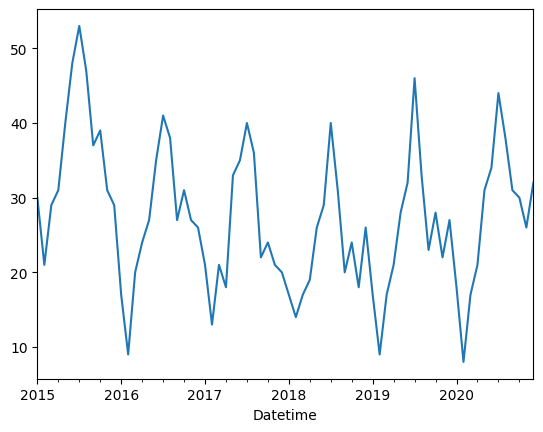

In [287]:
data['values'].plot()

### Визначення гіперпараметрів

In [288]:
test_set_size = 15
input_sliding_window_size = 3
output_sliding_window_size = 1

current_rnn_type = 'LSTM'
current_rnn_architecture = [1, 3, 1]    # first and last must be 1 = [1, ..., 1]
current_activation_function = nn.ReLU()
current_criterion = nn.MSELoss()

### Нормалізація, розбивка на sliding windows і розділення на вибірки

In [289]:
def create_sliding_windows(input_data, lookback, forecast_horizon):
    X, y = [], []
    for i in range(len(input_data) - lookback - forecast_horizon + 1):
        window_x = input_data[i:i + lookback].reshape(lookback, 1)
        window_y = input_data[i + lookback:i + lookback + forecast_horizon]
        X.append(window_x)
        y.append(window_y)
    return np.array(X), np.array(y)


def split_data(input_data_x, input_data_y, test_data_size):
    train_data_x = input_data_x[:-test_data_size]
    train_data_y = input_data_y[:-test_data_size]
    test_data_x = input_data_x[-test_data_size:]
    test_data_y = input_data_y[-test_data_size:]
    return train_data_x, train_data_y, test_data_x, test_data_y


original_values = data.values.squeeze()
real_test_values = original_values[-test_set_size:]

scaler = MinMaxScaler()  # StandardScaler()
scaled_values = scaler.fit_transform(original_values.reshape(-1, 1))

dataset_x, dataset_y = create_sliding_windows(scaled_values, input_sliding_window_size, output_sliding_window_size)
print('Total windows count =', len(dataset_x))

train_x, train_y, test_x, test_y = split_data(dataset_x, dataset_y, test_set_size)
print('Train size: X =', len(train_x), ' Y =', len(train_y))
print('Test size: X =', len(test_x), ' Y =', len(test_y))

Total windows count = 69
Train size: X = 54  Y = 54
Test size: X = 15  Y = 15


In [290]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

train_dataset = TimeSeriesDataset(train_x, train_y)
test_dataset  = TimeSeriesDataset(test_x, test_y)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1,  shuffle=False)

### Визначення гнучкого класу для рекуретних нейронних мереж

In [291]:
class FlexibleRNN(nn.Module):
    def __init__(self, rnn_type, activation_function, sliding_window_size, forecast_horizon, layer_sizes):
        super(FlexibleRNN, self).__init__()
        self.hidden_size = layer_sizes[1]
        self.num_layers = len(layer_sizes) - 2

        if rnn_type == 'RNN':
            self.rnn = nn.RNN(
                input_size=1, 
                hidden_size=self.hidden_size, 
                num_layers=self.num_layers,
                batch_first=True
            )
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=1,
                hidden_size=self.hidden_size,
                num_layers=self.num_layers,
                batch_first=True
            )
        else:
            raise ValueError("Invalid rnn_type. Choose from 'RNN' or 'LSTM'.")

        layers = []
        for i in range(1, len(layer_sizes) - 1):
            in_size = layer_sizes[i]
            out_size = layer_sizes[i+1] if (i+1 < len(layer_sizes) - 1) else forecast_horizon
            layers.append(nn.Linear(in_size, out_size))
            if i < len(layer_sizes) - 2:
                layers.append(activation_function)
                
        self.fc = nn.Sequential(*layers)

    def forward(self, x):
        batch_size = x.size(0)
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        if isinstance(self.rnn, nn.LSTM):
            c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
            rnn_out, _ = self.rnn(x, (h_0, c_0))
        else:
            rnn_out, _ = self.rnn(x, h_0)

        out = self.fc(rnn_out[:, -1, :])
        return out

### Просте навчання та перевірки результата

In [292]:
def train_model(model, criterion, train_loader, num_epochs=100, lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0

        for batch_x, batch_y in train_loader:
            outputs = model(batch_x)
            loss = criterion(outputs.squeeze(), batch_y.squeeze())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}")

    return train_losses

Created model:
FlexibleRNN(
  (rnn): LSTM(1, 3, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=3, out_features=1, bias=True)
  )
)
Epoch [50/1000] - Train Loss: 0.0479
Epoch [100/1000] - Train Loss: 0.0387
Epoch [150/1000] - Train Loss: 0.0398
Epoch [200/1000] - Train Loss: 0.0457
Epoch [250/1000] - Train Loss: 0.0337
Epoch [300/1000] - Train Loss: 0.0304
Epoch [350/1000] - Train Loss: 0.0284
Epoch [400/1000] - Train Loss: 0.0226
Epoch [450/1000] - Train Loss: 0.0221
Epoch [500/1000] - Train Loss: 0.0195
Epoch [550/1000] - Train Loss: 0.0215
Epoch [600/1000] - Train Loss: 0.0189
Epoch [650/1000] - Train Loss: 0.0228
Epoch [700/1000] - Train Loss: 0.0182
Epoch [750/1000] - Train Loss: 0.0187
Epoch [800/1000] - Train Loss: 0.0189
Epoch [850/1000] - Train Loss: 0.0221
Epoch [900/1000] - Train Loss: 0.0171
Epoch [950/1000] - Train Loss: 0.0180
Epoch [1000/1000] - Train Loss: 0.0196


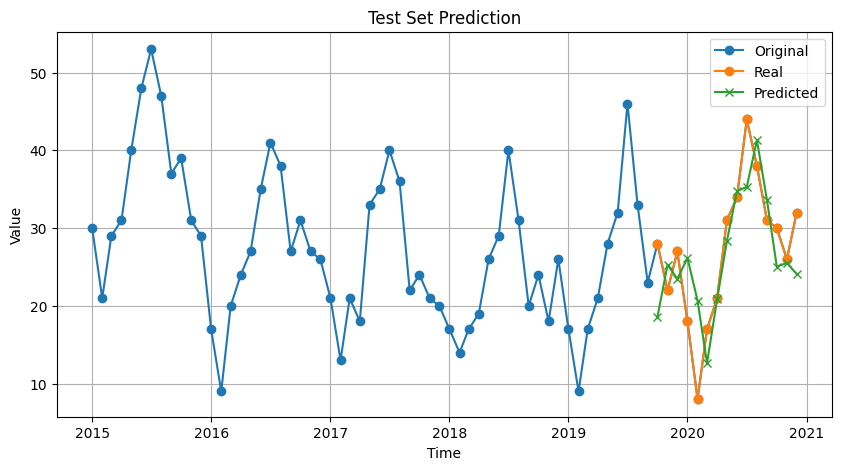

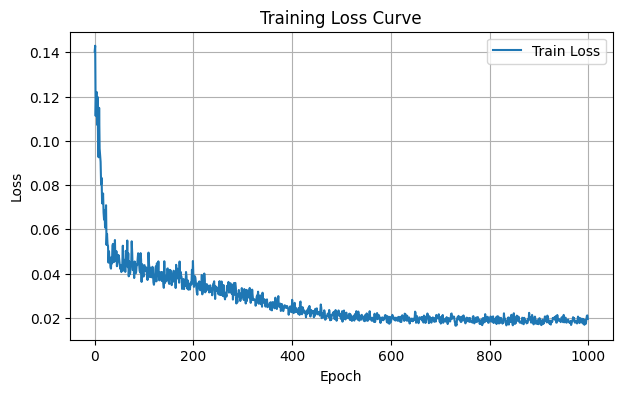

In [293]:
model = FlexibleRNN(
    rnn_type=current_rnn_type,
    activation_function=current_activation_function,
    sliding_window_size=input_sliding_window_size,
    forecast_horizon=output_sliding_window_size,
    layer_sizes=current_rnn_architecture
)

print("Created model:")
print(model)

train_losses = train_model(
    model=model,
    criterion=current_criterion,
    train_loader=train_loader,
    num_epochs=1000,
    lr=0.001
)


model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        y_pred = model(batch_x)
        predictions.append(y_pred.squeeze().item())
        actuals.append(batch_y.squeeze().item())

predictions = np.array(predictions)
actuals = np.array(actuals)

predictions_original_scale = scaler.inverse_transform(predictions.reshape(-1,1)).ravel()
actuals_original_scale = scaler.inverse_transform(actuals.reshape(-1, 1)).ravel()

test_index = data.index[-test_set_size:]

plt.figure(figsize=(10,5))
plt.plot(data.index, original_values, label='Original', marker='o')
plt.plot(test_index, actuals_original_scale, label='Real', marker='o')
plt.plot(test_index, predictions_original_scale, label='Predicted', marker='x')
plt.title("Test Set Prediction")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.plot(train_losses, label='Train Loss')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

### Перебір множини можливих конфігурацій та навчання з кросс-валідацією

In [294]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, SubsetRandomSampler

def train_and_validate(model, train_loader, val_loader, num_epochs=100, lr=0.01):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    best_model_state = None
    
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # ------ TRAIN ------
        model.train()
        total_train_loss = 0.0
        
        for batch_x, batch_y in train_loader:
            outputs = model(batch_x)
            loss = criterion(outputs.squeeze(), batch_y.squeeze())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # ------ VALIDATION ------
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                val_out = model(batch_x)
                val_loss = criterion(val_out.squeeze(), batch_y.squeeze())
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)


        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()


        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return best_val_loss, train_losses, val_losses

In [295]:
def cross_validate_rnn_architectures(
        rnn_types,
        architectures,
        dataset,
        k_folds=5,
        num_epochs=100,
        lr=0.01,
        sliding_window_size=3,
        forecast_horizon=1,
        activation_function=nn.ReLU(),
        used_batch_size=32
):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    results = {}

    for rnn_type in rnn_types:
        for arch in architectures:
            
            arch_name = f"{rnn_type}-arch-{'-'.join(map(str, arch))}"
            fold_losses = []

            for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
                train_subsampler = SubsetRandomSampler(train_idx)
                val_subsampler   = SubsetRandomSampler(val_idx)

                train_loader = DataLoader(dataset, batch_size=used_batch_size, sampler=train_subsampler)
                val_loader   = DataLoader(dataset, batch_size=used_batch_size, sampler=val_subsampler)

                model = FlexibleRNN(
                    rnn_type=rnn_type,
                    activation_function=activation_function,
                    sliding_window_size=sliding_window_size,
                    forecast_horizon=forecast_horizon,
                    layer_sizes=arch
                )

                val_loss, train_ls, val_ls = train_and_validate(
                    model,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    num_epochs=num_epochs,
                    lr=lr
                )

                fold_losses.append(val_loss)
                print(f"\n[{arch_name}] Fold {fold+1}/{k_folds} val_loss = {val_loss:.4f}")

            mean_loss = np.mean(fold_losses)
            std_loss  = np.std(fold_losses)

            results[arch_name] = {
                'mean_loss': float(mean_loss),
                'std_loss':  float(std_loss),
                'fold_losses': fold_losses
            }

    return results

Epoch [50/300] | Train Loss: 0.0215 | Val Loss: 0.0264
Epoch [100/300] | Train Loss: 0.0235 | Val Loss: 0.0282
Epoch [150/300] | Train Loss: 0.0178 | Val Loss: 0.0229
Epoch [200/300] | Train Loss: 0.0201 | Val Loss: 0.0275
Epoch [250/300] | Train Loss: 0.0215 | Val Loss: 0.0173
Epoch [300/300] | Train Loss: 0.0174 | Val Loss: 0.0246

[RNN-arch-1-3-1] Fold 1/5 val_loss = 0.0161
Epoch [50/300] | Train Loss: 0.0228 | Val Loss: 0.0221
Epoch [100/300] | Train Loss: 0.0189 | Val Loss: 0.0155
Epoch [150/300] | Train Loss: 0.0230 | Val Loss: 0.0212
Epoch [200/300] | Train Loss: 0.0201 | Val Loss: 0.0140
Epoch [250/300] | Train Loss: 0.0222 | Val Loss: 0.0139
Epoch [300/300] | Train Loss: 0.0220 | Val Loss: 0.0173

[RNN-arch-1-3-1] Fold 2/5 val_loss = 0.0127
Epoch [50/300] | Train Loss: 0.0192 | Val Loss: 0.0256
Epoch [100/300] | Train Loss: 0.0180 | Val Loss: 0.0323
Epoch [150/300] | Train Loss: 0.0181 | Val Loss: 0.0345
Epoch [200/300] | Train Loss: 0.0167 | Val Loss: 0.0320
Epoch [250/300] |

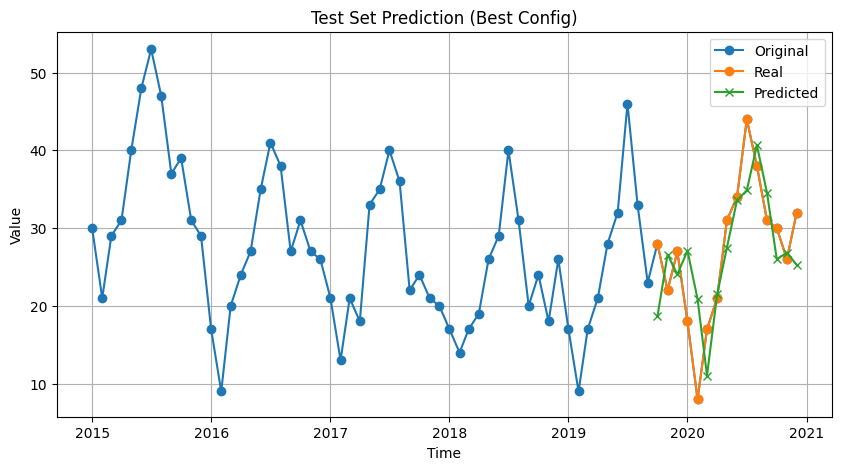

In [296]:
rnn_types = ['RNN', 'LSTM']

rnn_architectures = [
    [1, 3, 1],
    [1, 10, 1],        
    [1, 64, 1]  
]

cv_results = cross_validate_rnn_architectures(
    rnn_types=rnn_types,
    architectures=rnn_architectures,
    dataset=train_dataset, 
    k_folds=5,
    num_epochs=300,
    lr=0.005,
    sliding_window_size=input_sliding_window_size,
    forecast_horizon=output_sliding_window_size,
    activation_function=current_activation_function,
    used_batch_size=8
)


best_config = None
best_loss = float('inf')

for arch_name, info in cv_results.items():
    mean_loss = info['mean_loss']
    if mean_loss < best_loss:
        best_loss = mean_loss
        best_config = arch_name

print(f"\nBest: {best_config}, val_loss={best_loss:.4f}\n")

parts = best_config.split("-arch-")  # -> ["LSTM", "2-64-1"]
best_rnn_type = parts[0]
arch_str = parts[1].split("-")       # -> ["2", "64", "1"]
best_arch = list(map(int, arch_str)) # -> [2, 64, 1]
final_train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

best_model = FlexibleRNN(
    rnn_type=best_rnn_type,
    activation_function=current_activation_function,
    sliding_window_size=input_sliding_window_size,
    forecast_horizon=output_sliding_window_size,
    layer_sizes=best_arch
)

final_train_losses = train_model(
    model=best_model,
    criterion=current_criterion,
    train_loader=final_train_loader,
    num_epochs=300,
    lr=0.001 
)


best_model.eval()
predictions = []
actuals = []

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        y_pred = best_model(batch_x)
        predictions.append(y_pred.squeeze().item())
        actuals.append(batch_y.squeeze().item())

predictions = np.array(predictions)
actuals     = np.array(actuals)

predictions_original_scale = scaler.inverse_transform(predictions.reshape(-1,1)).ravel()
actuals_original_scale     = scaler.inverse_transform(actuals.reshape(-1, 1)).ravel()

test_index = data.index[-test_set_size:]

plt.figure(figsize=(10,5))
plt.plot(data.index, original_values, label='Original', marker='o')
plt.plot(test_index, actuals_original_scale, label='Real', marker='o')
plt.plot(test_index, predictions_original_scale, label='Predicted', marker='x')
plt.title("Test Set Prediction (Best Config)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [297]:
def summarize_cv_results(cv_results):
    rows = []
    for arch_name, info in cv_results.items():
        mean_loss = info['mean_loss']
        std_loss  = info['std_loss']
        fold_losses = info['fold_losses']
        rows.append([arch_name, mean_loss, std_loss, fold_losses])

    df = pd.DataFrame(rows, columns=['Architecture', 'Mean Loss', 'Std Loss', 'Fold Losses'])
    df.sort_values('Mean Loss', inplace=True)
    df.reset_index(drop=True, inplace=True)

    print("\n=== Cross-Validation Results (sorted by Mean Loss) ===")
    print(df)
    return df

df_cv = summarize_cv_results(cv_results)
df_cv


=== Cross-Validation Results (sorted by Mean Loss) ===
       Architecture  Mean Loss  Std Loss  \
0   RNN-arch-1-64-1   0.012780  0.005351   
1  LSTM-arch-1-64-1   0.012978  0.005191   
2  LSTM-arch-1-10-1   0.013215  0.003017   
3   LSTM-arch-1-3-1   0.013307  0.005706   
4    RNN-arch-1-3-1   0.014020  0.003876   
5   RNN-arch-1-10-1   0.014405  0.005566   

                                         Fold Losses  
0  [0.0052725543500855565, 0.01886339788325131, 0...  
1  [0.014009242877364159, 0.016664208145812154, 0...  
2  [0.011289190573734231, 0.00926571513991803, 0....  
3  [0.020959635177860036, 0.00882542267208919, 0....  
4  [0.016132453820318915, 0.012683246284723282, 0...  
5  [0.013105367892421782, 0.015995326335541904, 0...  


,Architecture,Mean Loss,Std Loss,Fold Losses
0,RNN-arch-1-64-1,0.012780,0.005351,"[0.0052725543500855565, 0.01886339788325131, 0..."
1,LSTM-arch-1-64-1,0.012978,0.005191,"[0.014009242877364159, 0.016664208145812154, 0..."
2,LSTM-arch-1-10-1,0.013215,0.003017,"[0.011289190573734231, 0.00926571513991803, 0...."
3,LSTM-arch-1-3-1,0.013307,0.005706,"[0.020959635177860036, 0.00882542267208919, 0...."
4,RNN-arch-1-3-1,0.014020,0.003876,"[0.016132453820318915, 0.012683246284723282, 0..."
5,RNN-arch-1-10-1,0.014405,0.005566,"[0.013105367892421782, 0.015995326335541904, 0..."


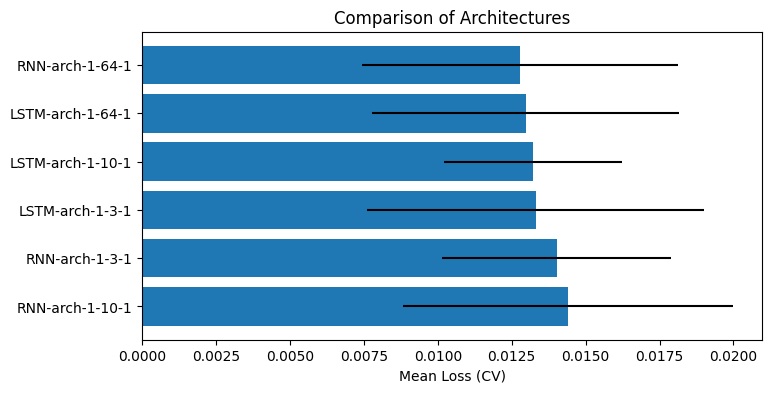

In [298]:
plt.figure(figsize=(8,4))

plt.barh(df_cv['Architecture'], df_cv['Mean Loss'], xerr=df_cv['Std Loss'])
plt.xlabel("Mean Loss (CV)")
plt.title("Comparison of Architectures")
plt.gca().invert_yaxis() 
plt.show()